# Sentiment Analysis

## 01. Logistic Regression

In this notebook, is the sentiment classifier using Logistic Regression for the IMDB reviews dataset. Firstly, importing the necessary libraries and ingesting the data from a CSV file.

In [124]:
import nltk
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# These are also needed to be downloaded
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# Using \t as delimeter and reading with pandas 
df = pd.read_csv("./imdb-reviews.csv", sep = '\t')

# Generate descriptive statistics
df.describe()

[nltk_data] Downloading package punkt to /Users/themis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/themis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/themis/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/themis/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/themis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/themis/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/themis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,rating
count,45008.000000
mean,5.481914
std,3.494293
min,1.000000
25%,2.000000
50%,7.000000
75%,9.000000
max,10.000000


### Exploring the Dataset

Then, taking a look at the shape of the data and its contents.

In [3]:
# Print the shape of the data
print(df.shape)

# Print first five rows of data
df.head()

(45008, 3)


,url,rating,review
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,I thought this was a quiet good movie. It was ...
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,Wagon Master is a very unique film amongst Joh...
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,This film has to be as near to perfect a film ...
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,I gave this 4 stars because it has a lot of in...
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,This movie is really genuine and random. It's ...


The reviews are what are going to be used to train the model, while the ratings to label the data. Then, getting a visual overview of the data provided and how they're distributed in each rating class.

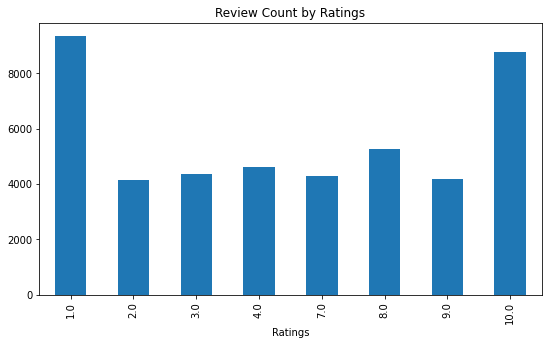

In [136]:
# A visual overview of our data
axis = df['rating'].value_counts().sort_index() \
    .plot(kind='bar', 
        title='Review Count by Ratings', 
        figsize=(9,5))

axis.set_xlabel('Ratings')
plt.show()

There is no representation of the 5 and 6 ratings and there is a nice distribution and a wide range of data. Then checking for class imbalance when tagged to positive and negative.

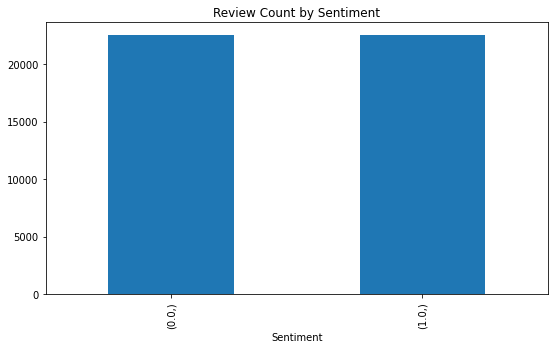

In [138]:
X = df['review']
Y = df[['rating']].copy()

# classify the ratings as positive and negative
Y.loc[Y['rating'] <= 5, 'rating'] = 0
Y.loc[Y['rating'] > 5, 'rating'] = 1

# A visual overview of our data when in two classes
axis = Y.value_counts().sort_index() \
    .plot(kind='bar', 
        title='Review Count by Sentiment', 
        figsize=(9,5))

axis.set_xlabel('Sentiment')
plt.show()

This is a very balanced dataset, with equal representation from both positive and negative sentiment classes.

## Data Preprocessing & Vectorisers

After confirming that the data provided is balanced different techniques of preprocessing and vectorisers will be explored. Lemmatization, stemming, as well as no preprocessing will be trialed. From vectorisers a comparison will be provided between CountVectoriser and Tf-Idf.

In order to gather the metrics from cross validation the function get_scores scores the model with a 5-fold cross validation in the metrics of precision, recall, f1-score and accuracy.

In [139]:
scoring = { 'precision' : make_scorer(precision_score, average = 'macro', zero_division=1),
           'recall' : make_scorer(recall_score, average = 'macro', zero_division=1),
           'f1_score' : make_scorer(f1_score, average = 'macro', zero_division=1), 
           'accuracy' : 'accuracy' }

F1_list = []
Acu_list = []
Prc_list = []
Rec_list = []

def get_scores(model, X, Y, scoring = 'accuracy', cv = 5) :
  score = cross_validate(model, X, Y, scoring = scoring, cv = cv)
  for key, value in score.items():
    print(key ,": ", value)
  return {key : np.mean(value) for key, value in score.items()}

### No Pre-Processing - Count Vectorizer

Initially, testing with the **Count Vectorizer** without any pre-processing and using 5-Fold cross validation.

In [15]:
# Split the data to train, validation for starters
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15)

# Using CountVectorizer
count_vectorizer = CountVectorizer()

# Fit the train data
X_train2 = count_vectorizer.fit_transform(X_train)

# For the validation data simply transform
X_val2 = count_vectorizer.transform(X_val)

# Using the Logistic Regression with defaults as classifier
classifier1 = LogisticRegression(max_iter=2000)
classifier1.fit(X_train2, np.ravel(Y_train))

scores_svc_bow = get_scores(classifier1, X_val2, np.ravel(Y_val), scoring = scoring, cv = 5)
print("\nMeans\n_______\nPrecision Score ", scores_svc_bow['test_precision'], "\nRecall Score ", scores_svc_bow['test_recall'], "\nF1 Score: ", scores_svc_bow['test_f1_score'], "\nAccuracy Score ", scores_svc_bow['test_accuracy'])

F1_list.append(scores_svc_bow['test_f1_score'])
Prc_list.append(scores_svc_bow['test_precision'])
Acu_list.append(scores_svc_bow['test_accuracy'])
Rec_list.append(scores_svc_bow['test_recall'])

fit_time :  [3.09547687 2.77001762 3.14085817 3.22292709 2.91837001]
score_time :  [0.00315213 0.00307822 0.00318575 0.00307369 0.00314307]
test_precision :  [0.85907423 0.84978521 0.86483058 0.86033103 0.86893858]
test_recall :  [0.85853123 0.84977142 0.86451749 0.85836099 0.86885356]
test_f1_score :  [0.8585535  0.8497406  0.86442295 0.85830012 0.8688727 ]
test_accuracy :  [0.85862324 0.84974093 0.86444444 0.85851852 0.86888889]

Means
_______
Precision score  0.860591927539763 
Recall score  0.8600069368035591 
F1 Score:  0.8599779724958065 
Accuracy score  0.860043205307454


The model performs similarly well along all five batches. Then testing with TF-IDF vectorizer. Count Vectorizer simply maps the number of frequencies with respect to index where TF-IDF considers the number of times a word appears with the number of ducuments it appears in.

Term frequency:
${\displaystyle \mathrm {tf} (t,d)={\frac {f_{t,d}}{\sum _{t'\in d}{f_{t',d}}}}}$

Inverse document frequency:
$\mathrm{idf}(t, D) =  \log \frac{N}{|\{d \in D: t \in d\}|}$

Term frequency - inverse document frequency:
${\displaystyle \mathrm {tfidf} (t,d,D)=\mathrm {tf} (t,d)\cdot \mathrm {idf} (t,D)}$

### No Pre-Processing - TF-IDF Vectorizer

In [16]:
# Split the data to train, validation for starters
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15)

# Using TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit the train data
X_train2 = vectorizer.fit_transform(X_train)

# For the validation data simply transform
X_val2 = vectorizer.transform(X_val)

# Using the Logistic Regression with defaults as classifier
classifier1 = LogisticRegression(max_iter=2000)
classifier1.fit(X_train2, np.ravel(Y_train))

scores_svc_bow = get_scores(classifier1, X_val2, np.ravel(Y_val), scoring = scoring, cv = 5)
print("\nMeans\n_______\nPrecision Score ", scores_svc_bow['test_precision'], "\nRecall Score ", scores_svc_bow['test_recall'], "\nF1 Score: ", scores_svc_bow['test_f1_score'], "\nAccuracy Score ", scores_svc_bow['test_accuracy'])

F1_list.append(scores_svc_bow['test_f1_score'])
Prc_list.append(scores_svc_bow['test_precision'])
Acu_list.append(scores_svc_bow['test_accuracy'])
Rec_list.append(scores_svc_bow['test_recall'])

fit_time :  [0.2693758  0.34920597 0.37315702 0.27655911 0.66824603]
score_time :  [0.00328326 0.00314212 0.00390697 0.00340366 0.00353479]
test_precision :  [0.87913132 0.87665614 0.85866737 0.85246391 0.86927672]
test_recall :  [0.87851313 0.87631934 0.85847292 0.85097319 0.86881716]
test_f1_score :  [0.87854449 0.87634884 0.85849049 0.85093043 0.86883642]
test_accuracy :  [0.87860844 0.87638786 0.85851852 0.85111111 0.86888889]

Means
_______
Precision score  0.8672390912222092 
Recall score  0.8666191497126174 
F1 Score:  0.8666301337108548 
Accuracy score  0.8667029635112536


Along all scores the TF-IDF performs marginally better than the Count Vectoriser.

### Stemming

For Stemming the class StemmingTokenizer is defined using the Snowball Stemmer, where the english stopwords as well as the punctuation from the reviews are removed.

In [17]:
# Stemming class using the Snowball Stemmer
class StemmingTokenizer:
    def __init__(self) -> None:

        # Stemming
        self.snow = SnowballStemmer("english")

    def __call__(self, review):

        tokens = nltk.word_tokenize(review)

         # Keep a list of the stop words from NLTK
        stopwords_list = stopwords.words('english') 

        # List of words without stopwords or punctuation
        words = []
        for token in tokens:
            if token not in stopwords_list and token not in string.punctuation:
                words.append(token)
        
        return [self.snow.stem(token) \
            for token in words]

### Snowball Stemmer - Count Vectorizer

In [18]:
# Split the data to train, validation for starters
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15)

# Using CountVectorizer and Stemming
count_vectorizer = CountVectorizer(tokenizer=StemmingTokenizer())

# Fit the train data
X_train2 = count_vectorizer.fit_transform(X_train)

# For the validation data simply transform
X_val2 = count_vectorizer.transform(X_val)

# Using the Logistic Regression with defaults as classifier
classifier1 = LogisticRegression(max_iter=2000)
classifier1.fit(X_train2, np.ravel(Y_train))

scores_svc_bow = get_scores(classifier1, X_val2, np.ravel(Y_val), scoring = scoring, cv = 5)
print("\nMeans\n_______\nPrecision Score ", scores_svc_bow['test_precision'], "\nRecall Score ", scores_svc_bow['test_recall'], "\nF1 Score: ", scores_svc_bow['test_f1_score'], "\nAccuracy Score ", scores_svc_bow['test_accuracy'])

F1_list.append(scores_svc_bow['test_f1_score'])
Prc_list.append(scores_svc_bow['test_precision'])
Acu_list.append(scores_svc_bow['test_accuracy'])
Rec_list.append(scores_svc_bow['test_recall'])

fit_time :  [2.02389407 2.0800941  2.08989286 2.15946293 2.12601089]
score_time :  [0.00315213 0.00307202 0.00311708 0.00380993 0.00313926]
test_precision :  [0.84460549 0.87338106 0.84105266 0.85111408 0.86222101]
test_recall :  [0.84390766 0.87276734 0.84078543 0.85111639 0.86222101]
test_f1_score :  [0.84375228 0.87264329 0.84071548 0.85111103 0.86222101]
test_accuracy :  [0.84381939 0.8726869  0.84074074 0.85111111 0.86222222]

Means
_______
Precision Score  0.8544748590504161 
Recall Score  0.8541595658359091 
F1 Score:  0.8540886181441352 
Accuracy Score  0.8541160731419799


Stemming as can be seen above from the results performs similarly in this particular dataset, but it takes more time to train, which is normal because of the data preprocessing.

### Porter Stemmer - Count Vectorizer

In [21]:
# Stemming class using the Porter Stemmer
class StemmingPorterTokenizer:
    def __init__(self) -> None:

        # Stemming
        self.port = PorterStemmer()

    def __call__(self, review):

        tokens = nltk.word_tokenize(review)
        
        return [self.port.stem(token) \
            for token in tokens]

In [22]:
# Split the data to train, validation for starters
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15)

# Using CountVectorizer and Stemming
count_vectorizer = CountVectorizer(tokenizer=StemmingPorterTokenizer())

# Fit the train data
X_train2 = count_vectorizer.fit_transform(X_train)

# For the validation data simply transform
X_val2 = count_vectorizer.transform(X_val)

# Using the Logistic Regression with defaults as classifier
classifier1 = LogisticRegression(max_iter=2000)
classifier1.fit(X_train2, np.ravel(Y_train))

scores_svc_bow = get_scores(classifier1, X_val2, np.ravel(Y_val), scoring = scoring, cv = 5)
print("\nMeans\n_______\nPrecision Score ", scores_svc_bow['test_precision'], "\nRecall Score ", scores_svc_bow['test_recall'], "\nF1 Score: ", scores_svc_bow['test_f1_score'], "\nAccuracy Score ", scores_svc_bow['test_accuracy'])

F1_list.append(scores_svc_bow['test_f1_score'])
Prc_list.append(scores_svc_bow['test_precision'])
Acu_list.append(scores_svc_bow['test_accuracy'])
Rec_list.append(scores_svc_bow['test_recall'])

fit_time :  [5.73239899 5.04166508 5.39643002 5.33781695 4.87409472]
score_time :  [0.00309014 0.00321817 0.00337219 0.00320387 0.00322318]
test_precision :  [0.86874242 0.86987432 0.8533005  0.86368578 0.83775348]
test_recall :  [0.8678353  0.86947532 0.85319499 0.86358357 0.83763111]
test_f1_score :  [0.86805772 0.86960604 0.85324024 0.86362708 0.83768079]
test_accuracy :  [0.86824574 0.86972613 0.85333333 0.8637037  0.83777778]

Means
_______
Precision Score  0.858671299887088 
Recall Score  0.85834405816756 
F1 Score:  0.8584423736955618 
Accuracy Score  0.8585573375003428


Porter performed similarly, but took more time to complete, even without the step of removing the stopwords. Finally, testing the snowball stemmer with Tf-Idf.

### Snowball Stemmer - TF-IDF Vectorizer

In [23]:
# Split the data to train, validation for starters
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15)

# Using TfIdf Vectorizer and Snowball Stemming
vectorizer = TfidfVectorizer(tokenizer=StemmingTokenizer())

# Fit the train data
X_train2 = vectorizer.fit_transform(X_train)

# For the validation data simply transform
X_val2 = vectorizer.transform(X_val)

# Using the Logistic Regression with defaults as classifier
classifier1 = LogisticRegression(max_iter=2000)
classifier1.fit(X_train2, np.ravel(Y_train))

scores_svc_bow = get_scores(classifier1, X_val2, np.ravel(Y_val), scoring = scoring, cv = 5)
print("\nMeans\n_______\nPrecision Score ", scores_svc_bow['test_precision'], "\nRecall Score ", scores_svc_bow['test_recall'], "\nF1 Score: ", scores_svc_bow['test_f1_score'], "\nAccuracy Score ", scores_svc_bow['test_accuracy'])

F1_list.append(scores_svc_bow['test_f1_score'])
Prc_list.append(scores_svc_bow['test_precision'])
Acu_list.append(scores_svc_bow['test_accuracy'])
Rec_list.append(scores_svc_bow['test_recall'])

fit_time :  [0.35500312 0.43515372 0.41313791 0.64462376 0.4623487 ]
score_time :  [0.00319886 0.00305414 0.00309277 0.00300336 0.00308609]
test_precision :  [0.87197779 0.86715224 0.8637227  0.86362637 0.86345302]
test_recall :  [0.87199246 0.86690118 0.86316944 0.86315627 0.86312993]
test_f1_score :  [0.87194643 0.86675302 0.8629298  0.86293581 0.86294604]
test_accuracy :  [0.87194671 0.86676536 0.86296296 0.86296296 0.86296296]

Means
_______
Precision Score  0.8659864231088156 
Recall Score  0.8656698530617885 
F1 Score:  0.8655022196508545 
Accuracy Score  0.865520190805165


### Lemmatisation

To perform Lemmatisation the pos_wordnet function to return the wordnet is defined and the Lemmatizing Tokenizer class in a similar way to the Tokenizers before, by removing stopwords and punctuation, using the WordNetLemmatizer.

In [25]:
# Returns equivalent wordnet pos
def pos_wordnet(tag):
    if tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

class LemmatizingTokenizer:
    def __init__(self) -> None:
        self.wnl = WordNetLemmatizer()
    def __call__(self, review):
        tokens = nltk.word_tokenize(review)
         # Keep a list of the stop words from NLTK
        stopwords_list = stopwords.words('english') 
        # List of words without stopwords or punctuation
        words = []
        for token in tokens:
            if token not in stopwords_list and token not in string.punctuation:
                words.append(token)
        tokens_tagged = nltk.pos_tag(words)
        return [self.wnl.lemmatize(token, pos=pos_wordnet(tag)) \
            for token, tag in tokens_tagged]

### Lemmatizer - Count Vectorizer

In [26]:
# Split the data to train, validation for starters
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15)

# Using CountVectorizer and Stemming
count_vectorizer = CountVectorizer(tokenizer=LemmatizingTokenizer())

# Fit the train data
X_train2 = count_vectorizer.fit_transform(X_train)

# For the validation data simply transform
X_val2 = count_vectorizer.transform(X_val)

# Using the Logistic Regression with defaults as classifier
classifier1 = LogisticRegression(max_iter=2000)
classifier1.fit(X_train2, np.ravel(Y_train))

scores_svc_bow = get_scores(classifier1, X_val2, np.ravel(Y_val), scoring = scoring, cv = 5)
print("\nMeans\n_______\nPrecision Score ", scores_svc_bow['test_precision'], "\nRecall Score ", scores_svc_bow['test_recall'], "\nF1 Score: ", scores_svc_bow['test_f1_score'], "\nAccuracy Score ", scores_svc_bow['test_accuracy'])

F1_list.append(scores_svc_bow['test_f1_score'])
Prc_list.append(scores_svc_bow['test_precision'])
Acu_list.append(scores_svc_bow['test_accuracy'])
Rec_list.append(scores_svc_bow['test_recall'])

fit_time :  [2.3063128  2.18511105 2.24313092 2.22823596 2.07377672]
score_time :  [0.00316191 0.00313187 0.00332594 0.00313902 0.00319433]
test_precision :  [0.86038407 0.86089242 0.84445786 0.85046729 0.84524656]
test_recall :  [0.86011396 0.86084813 0.84443971 0.84962963 0.84518519]
test_f1_score :  [0.86007879 0.86084008 0.84444137 0.84953972 0.8451783 ]
test_accuracy :  [0.86010363 0.86084382 0.84444444 0.84962963 0.84518519]

Means
_______
Precision Score  0.852289639503881 
Recall Score  0.8520433229218896 
F1 Score:  0.8520156546403339 
Accuracy Score  0.8520413411190614


With the count vectorizer the completion time was longer and the results were similar to the ones without any preprocessing.

### Lemmatizer - TF-IDF Vectorizer

In [27]:
# Split the data to train, validation for starters
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15)

# Using TfIdf Vectorizer and Snowball Stemming
vectorizer = TfidfVectorizer(tokenizer=LemmatizingTokenizer())

# Fit the train data
X_train2 = vectorizer.fit_transform(X_train)

# For the validation data simply transform
X_val2 = vectorizer.transform(X_val)

# Using the Logistic Regression with defaults as classifier
classifier1 = LogisticRegression(max_iter=2000)
classifier1.fit(X_train2, np.ravel(Y_train))

scores_svc_bow = get_scores(classifier1, X_val2, np.ravel(Y_val), scoring = scoring, cv = 5)
print("\nMeans\n_______\nPrecision Score ", scores_svc_bow['test_precision'], "\nRecall Score ", scores_svc_bow['test_recall'], "\nF1 Score: ", scores_svc_bow['test_f1_score'], "\nAccuracy Score ", scores_svc_bow['test_accuracy'])

F1_list.append(scores_svc_bow['test_f1_score'])
Prc_list.append(scores_svc_bow['test_precision'])
Acu_list.append(scores_svc_bow['test_accuracy'])
Rec_list.append(scores_svc_bow['test_recall'])

fit_time :  [ 0.55524015 32.41629863  0.72284293  0.62909913  0.59657097]
score_time :  [0.0030899  0.00513411 0.00308919 0.00317287 0.00300002]
test_precision :  [0.87056925 0.87086404 0.84946445 0.87009722 0.85148553]
test_recall :  [0.86910742 0.87052755 0.84894902 0.86831016 0.85118389]
test_f1_score :  [0.86887099 0.87044332 0.84884112 0.86800794 0.8510875 ]
test_accuracy :  [0.86898594 0.87046632 0.84888889 0.86814815 0.85111111]

Means
_______
Precision Score  0.8624960967547295 
Recall Score  0.8616156073288785 
F1 Score:  0.8614501716760703 
Accuracy Score  0.8615200811470242


The results were better than expected, but it took longer to complete, which considering that later the iterations will be increased needs to be taken under consideration.

### Result Analysis

I'll plot below the results of these tests with each pre-processing technique and vectorizer.

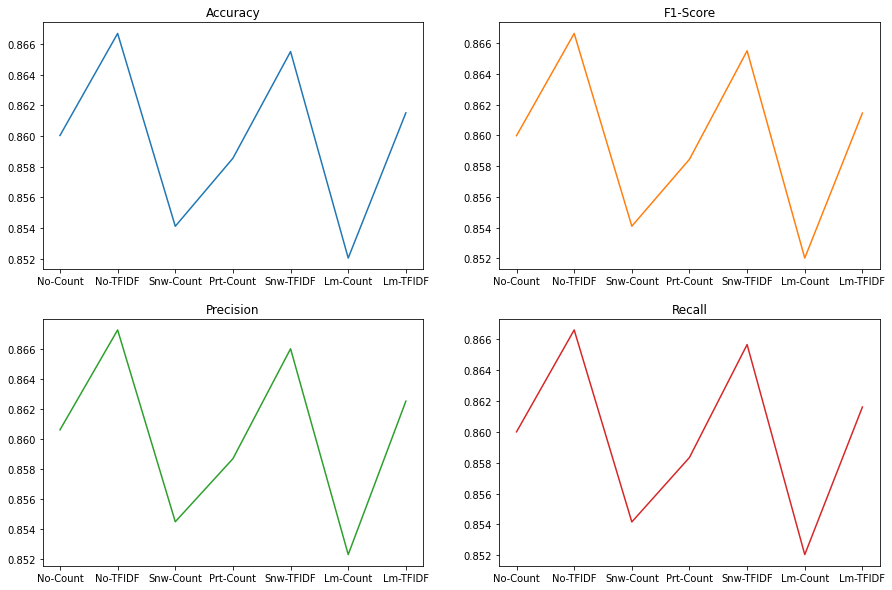

In [71]:
label_list = ["No-Count","No-TFIDF","Snw-Count","Prt-Count","Snw-TFIDF","Lm-Count","Lm-TFIDF"]
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(label_list, Acu_list)
axs[0, 0].set_title('Accuracy')
axs[0, 1].plot(label_list, F1_list, 'tab:orange')
axs[0, 1].set_title('F1-Score')
axs[1, 0].plot(label_list, Prc_list, 'tab:green')
axs[1, 0].set_title('Precision')
axs[1, 1].plot(label_list, Rec_list, 'tab:red')
axs[1, 1].set_title('Recall')
plt.show()

The best performing is surprisingly the model without any pre-processing of the data, but this also would be sensitive to overfitting. Lemmatization performs surprisingly the worst in this particular dataset. So the Snow-Stemmer will be selected for the future models, since it performs quite similarly, but would better generalise on data that the model hasn't seen.  

To also make sure that the TF-IDF vectorizer in combination with the Stemming Tokenizer is working correctly I will explore with the use of wordmaps the tokens that have a negative and positive sentiment according to their weights. 

Most positive words:
well 3.7527938276669195
favorit 5.2743342180614
hilari 4.469925525566132
love 5.665440393230273
great 8.20273907222407
beauti 4.453384778241309
best 5.6254550404602
excel 7.4642686920241985
amaz 4.883039157985525
fun 4.007338863630658
definit 4.4364358909394115
perfect 6.256472647737764
today 4.145326197288156
enjoy 5.775341881029761
surpris 3.609580107028772
7 3.5509482270317365
brilliant 4.879586302858558
superb 4.415286868190301
7/10 4.897134844699736
8/10 3.926002554192046


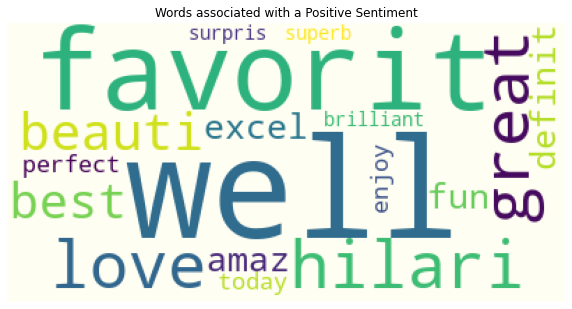

In [74]:
# Split the data to train, validation for starters
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15)

# Using TfIdf Vectorizer and Snowball Stemming
vectorizer = TfidfVectorizer(tokenizer=StemmingTokenizer())

# Fit the train data
X_train2 = vectorizer.fit_transform(X_train)

# For the validation data simply transform
X_val2 = vectorizer.transform(X_val)

word_index_map = vectorizer.vocabulary_

# Using the Logistic Regression with defaults as classifier
classifier = LogisticRegression(max_iter=2000)
classifier.fit(X_train2, np.ravel(Y_train))

# Dictionary to hold the positive words
positive_dict = {}

threshold = 3.5
print("Most positive words:")
for word, index in word_index_map.items():
    weight = classifier.coef_[0][index]
    if weight > threshold:
        positive_dict[word]=weight
        print(word, weight)

f = plt.figure()
f.set_size_inches(10, 9)
wordcloud = WordCloud(max_font_size=100, max_words=30, background_color="#FFFEF2").generate(' '.join(x for x in positive_dict.keys()))
plt.axis('off')
plt.title("Words associated with a Positive Sentiment")
plt.imshow(wordcloud)
plt.show()

The words associated with a positive sentiment of the model are the ones we would expect. Looking at the wordmap of course they are reduced to their stems and some altered (e.g. beauti instead of beauty). Then creating a similar dictionary for the negative sentiment words.

Most Negative words:
would -3.9221060872759854
bad -8.880510962721447
minut -3.967044685614564
terribl -6.092354595573991
poor -7.7094683086470495
worst -10.41709642139968
oh -3.65059763305208
noth -5.753600035563605
disappoint -5.651817858992161
lack -4.441579178964641
unfortun -4.04117006958548
instead -4.175161545115713
suppos -5.143976763277438
aw -7.838672136173833
bore -6.876879080517705
embarrass -3.591973692082955
lame -3.811570637572886
ridicul -3.6464684796635085
wast -8.811257238005886
stupid -4.693016784124574
save -4.7966444990642
avoid -3.767771466251372
script -3.829397815762526
pointless -3.535742087474511
dull -4.664476740933123
fail -5.422889657415968
wors -5.493527316213795
annoy -4.514195720011761
horribl -5.273552049529247
laughabl -3.5187221329776546
4/10 -4.149459126213404
unless -3.5919077982491503
mess -3.581511110125811


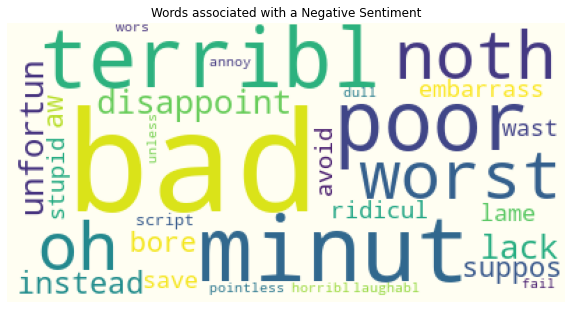

In [75]:
# Similar process for negative sentiment
word_index_map = vectorizer.vocabulary_
negative_dict = {}

threshold = 3.5
print("Most Negative words:")
for word, index in word_index_map.items():
    weight = classifier.coef_[0][index]
    if weight < -threshold:
        negative_dict[word]=weight
        print(word, weight)

f = plt.figure()
f.set_size_inches(10, 9)
wordcloud = WordCloud(max_font_size=100, max_words=30, background_color="#FFFEF2").generate(' '.join(x for x in negative_dict.keys()))
plt.axis('off')
plt.title("Words associated with a Negative Sentiment")
plt.imshow(wordcloud)
plt.show()

Barring a few exceptions, again the words we would expect to be considered negative are classified as such. So it is clear that the vectoriser along with the Stemming tokenizer is working correctly.

## Model Training & Learning Curves

Plotting the learning curves between three optimizers to make sure the model isn't overfitting or underfitting as it is learning. Since sklearn's LogisticRegression doesn't support the simple stochastic gradient descent I'll implement this using SGDClassifier with logloss.

### Stochastic Gradient Descent

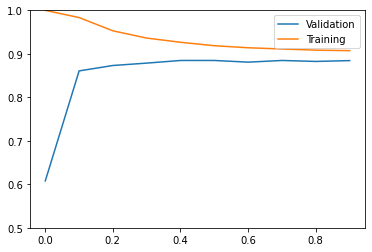

In [84]:
# Classify the ratings as positive and negative
X = df['review']
Y = df[['rating']].copy()
Y.loc[Y['rating'] <= 5, 'rating'] = 0
Y.loc[Y['rating'] > 5, 'rating'] = 1

# Initial split keeping the validation data separate
X, X_val, Y, Y_val = train_test_split(X, Y, test_size=0.15)

# Lists of the results
aculist=[]
aculist_train=[]
list_sample_size=[]

for i in range(10):
    # Split the data to train, validation for starters
    X_train, X_notused, Y_train, Y_notused = train_test_split(X, Y, test_size=1 - (i * 0.1 + 0.001))

    # Training the model and fitting the data
    tfidif_vectorizer = TfidfVectorizer(tokenizer=StemmingTokenizer())
    model = SGDClassifier(max_iter=3000, loss='log_loss')
    X_train = tfidif_vectorizer.fit_transform(X_train)
    x_val_results = tfidif_vectorizer.transform(X_val)
    model.fit(X_train, np.ravel(Y_train))

    # Making the predictions
    aculist_train.append(model.score(X_train, Y_train))
    aculist.append(model.score(x_val_results, Y_val))
    list_sample_size.append(i * 0.1 + 0.001)

# In the plots I'll use a range of 0.5 1 so the difference is easily observed
plt.plot(list_sample_size, aculist)
plt.plot(list_sample_size, aculist_train)
plt.ylim([0.5, 1.0])
plt.legend(["Validation", "Training"])
plt.show()


With the Gradient Descent algorithm as the training sample size increases the model moves from overfitting till the validation and training results are quite similar in accuracy.

### Liblinear with Cross Validation

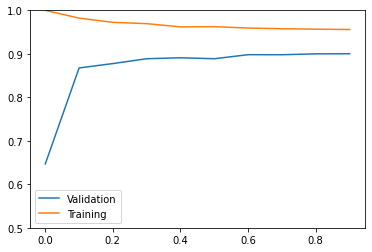

In [82]:
# Classify the ratings as positive and negative
X = df['review']
Y = df[['rating']].copy()
Y.loc[Y['rating'] <= 5, 'rating'] = 0
Y.loc[Y['rating'] > 5, 'rating'] = 1

# Initial split keeping the validation data separate
X, X_val, Y, Y_val = train_test_split(X, Y, test_size=0.15)

# Lists of the results
aculist=[]
aculist_train=[]
list_sample_size=[]

for i in range(10):
    # Split the data to train, validation for starters
    X_train, X_notused, Y_train, Y_notused = train_test_split(X, Y, test_size=1 - (i * 0.1 + 0.001))

    # Training the model and fitting the data
    tfidif_vectorizer = TfidfVectorizer(tokenizer=StemmingTokenizer())
    model = LogisticRegressionCV(cv=5, solver='liblinear', penalty='l2')
    X_train = tfidif_vectorizer.fit_transform(X_train)
    x_val_results = tfidif_vectorizer.transform(X_val)
    model.fit(X_train, np.ravel(Y_train))

    # Making the predictions
    aculist_train.append(model.score(X_train, Y_train))
    aculist.append(model.score(x_val_results, Y_val))
    list_sample_size.append(i * 0.1 + 0.001)

# In the plots I'll use a range of 0.5 1 so the difference is easily observed
plt.plot(list_sample_size, aculist)
plt.plot(list_sample_size, aculist_train)
plt.ylim([0.5, 1.0])
plt.legend(["Validation", "Training"])
plt.show()

In a similar way with the liblinear solver, as the sample size increases there is a divergence.

### Stochastic Average Gradient Descent

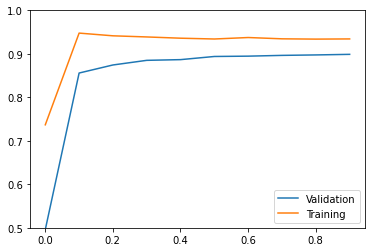

In [83]:
# Classify the ratings as positive and negative
X = df['review']
Y = df[['rating']].copy()
Y.loc[Y['rating'] <= 5, 'rating'] = 0
Y.loc[Y['rating'] > 5, 'rating'] = 1

# Initial split keeping the validation data separate
X, X_val, Y, Y_val = train_test_split(X, Y, test_size=0.15)

# Lists of the results
aculist=[]
aculist_train=[]
list_sample_size=[]

for i in range(10):
    # Split the data to train, validation for starters
    X_train, X_notused, Y_train, Y_notused = train_test_split(X, Y, test_size=1 - (i * 0.1 + 0.001))

    # Training the model and fitting the data
    tfidif_vectorizer = TfidfVectorizer()
    model = LogisticRegression(max_iter=3000, solver="sag")
    X_train = tfidif_vectorizer.fit_transform(X_train)
    x_val_results = tfidif_vectorizer.transform(X_val)
    model.fit(X_train, np.ravel(Y_train))

    # Making the predictions
    aculist_train.append(model.score(X_train, Y_train))
    aculist.append(model.score(x_val_results, Y_val))
    list_sample_size.append(i * 0.1 + 0.001)

# In the plots I'll use a range of 0.5 1 so the difference is easily observed
plt.plot(list_sample_size, aculist)
plt.plot(list_sample_size, aculist_train)
plt.ylim([0.5, 1.0])
plt.legend(["Validation", "Training"])
plt.show()

Now in this particular test with Stochastic Average Gradient descent, without cross validation and more importantly the Stemmer made the model bad at predicting with a small sample size even on the training data. But in general it is good to know that with different optimization algorithms the logistic regression still as the model learns show no signs of overfitting or underfitting with a good training set size.

## Optimiser Evaluation & Regularisation

Finally, examining the optimizers, each parametrised with the penalty that they perform better. I'll use Ridge Regression, when L2 is available to avoid overfitting and Lasso Regression in the solvers that this isn't available. 

The gradient descent algorithm will be implemented with SGDClassifier as before, while the rest of the solvers of LogisticRegression will be passed in each iteration.

In [92]:
# The lists to keep the results
solvers = ["gd", "liblinear", "newton-cg", "lbfgs", "sag", "saga"]
f1scores_list = []
precision_list = []
recall_list = []
accuracy_list = []

# Classify the ratings as positive and negative
X = df['review']
Y = df[['rating']].copy()
Y.loc[Y['rating'] <= 5, 'rating'] = 0
Y.loc[Y['rating'] > 5, 'rating'] = 1

# Initially the gradient descent
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15)
tfidif_vectorizer = TfidfVectorizer()
X_train2 = tfidif_vectorizer.fit_transform(X_train)
X_val2 = tfidif_vectorizer.transform(X_val)
classifier = SGDClassifier(max_iter=3000, loss='log_loss')
classifier.fit(X_train2, np.ravel(Y_train))
predicted_val = classifier.predict(X_val2)

# Add the results
f1scores_list.append(f1_score(Y_val, predicted_val))
accuracy_list.append(accuracy_score(Y_val, predicted_val))
precision_list.append(precision_score(Y_val, predicted_val))
recall_list.append(recall_score(Y_val, predicted_val))

# Then the logistic regression solvers
for solver in solvers[1:]:

    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15)
    tfidif_vectorizer = TfidfVectorizer()
    X_train2 = tfidif_vectorizer.fit_transform(X_train)
    X_val2 = tfidif_vectorizer.transform(X_val)
    classifier = LogisticRegression(max_iter=3000, solver=solver)
    classifier.fit(X_train2, np.ravel(Y_train))
    predicted_val = classifier.predict(X_val2)

    # Add the scores in the list
    f1scores_list.append(f1_score(Y_val, predicted_val))
    accuracy_list.append(accuracy_score(Y_val, predicted_val))
    precision_list.append(precision_score(Y_val, predicted_val))
    recall_list.append(recall_score(Y_val, predicted_val))

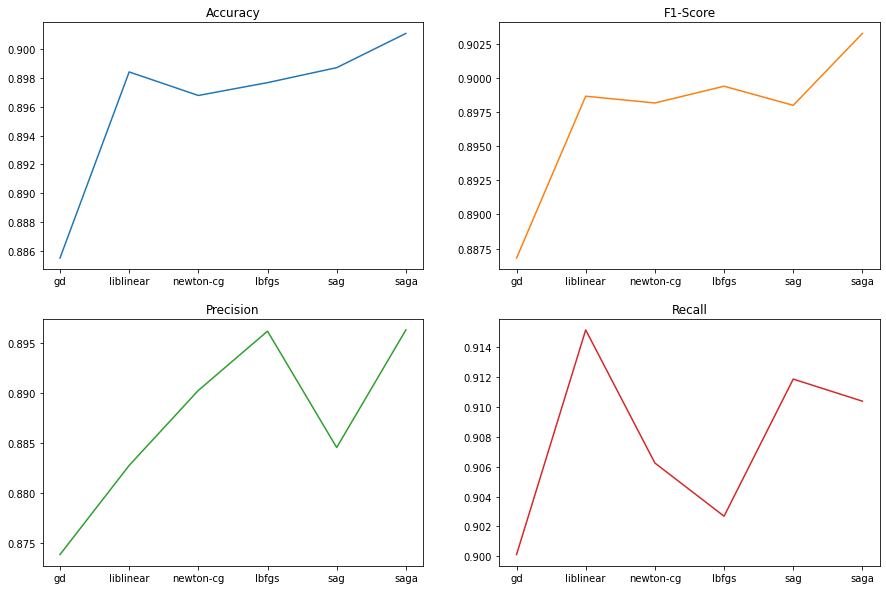

In [94]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(solvers, accuracy_list)
axs[0, 0].set_title('Accuracy')
axs[0, 1].plot(solvers, f1scores_list, 'tab:orange')
axs[0, 1].set_title('F1-Score')
axs[1, 0].plot(solvers, precision_list, 'tab:green')
axs[1, 0].set_title('Precision')
axs[1, 1].plot(solvers, recall_list, 'tab:red')
axs[1, 1].set_title('Recall')
plt.show()

Among the different solvers used in linear regression, gradient descent performs the worst in terms of accuracy and other evaluation metrics. The lbfgs solver has a low recall, indicating that it doesn't accurately predict positive reviews as positive sentiment compared to the other solvers. The remaining optimizers show marginal differences in terms of f1-score and accuracy. However, overall, the Saga solver performs better across all metrics.

To provide a visual representation of the accurate predictions, I will also plot the confusion matrices."

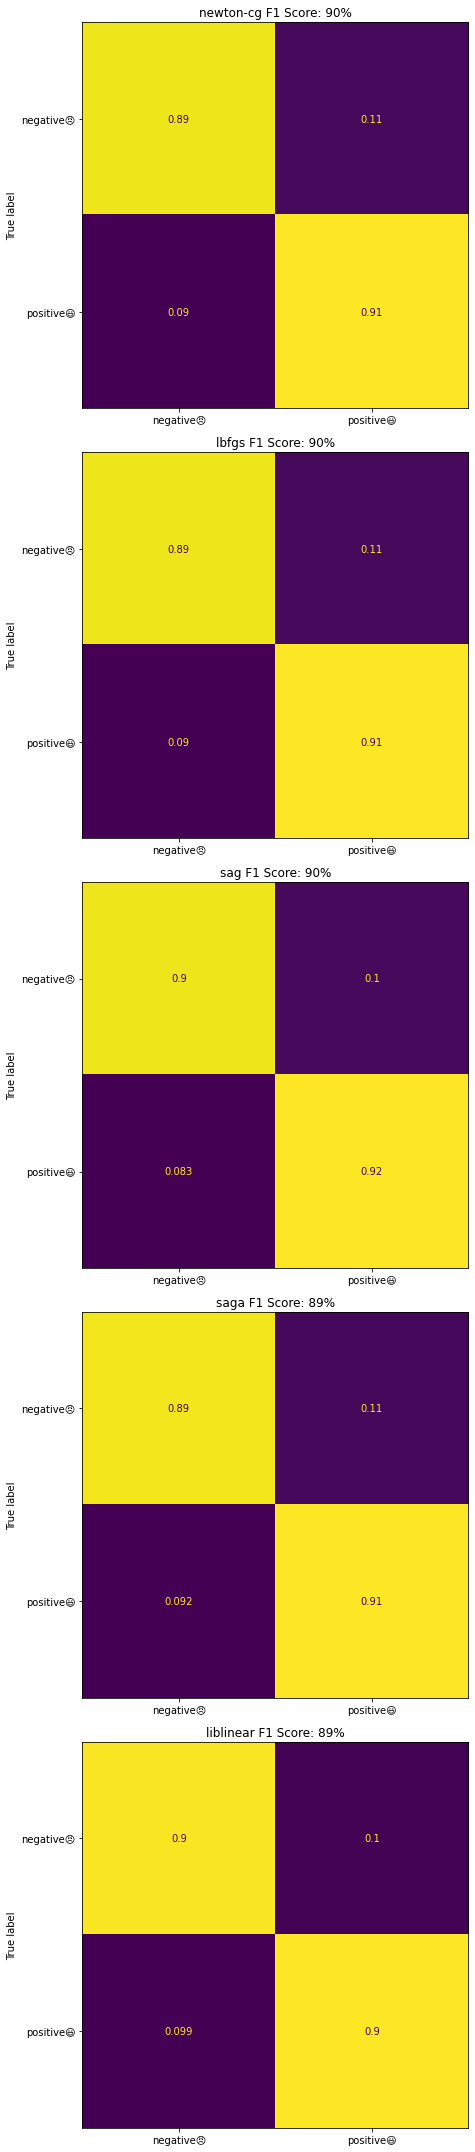

In [102]:
# I use subplots to plot them vertically so the results are more clear
f, axes = plt.subplots(5, 1, figsize=(30, 30))
i=0
for solver in solvers[1:]:
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15)
    tfidif_vectorizer = TfidfVectorizer()
    X_train2 = tfidif_vectorizer.fit_transform(X_train)
    X_val2 = tfidif_vectorizer.transform(X_val)
    classifier = LogisticRegression(max_iter=3000, solver=solver)
    classifier.fit(X_train2, np.ravel(Y_train))
    predicted_val = classifier.predict(X_val2)

    # Labels so it's more clear
    names =['negative😠', 'positive😃']
    cfmatr = confusion_matrix(Y_val, predicted_val, normalize='true')
    cmd = ConfusionMatrixDisplay(cfmatr, display_labels=names)
    cmd.plot(ax=axes[i-1])
    cmd.ax_.set_title(solver+ " F1 Score: "+str(int(f1_score(Y_val, predicted_val)*100))+"%")
    cmd.im_.colorbar.remove()
    cmd.ax_.set_xlabel('')
    i+=1

# for the plotting of the confusion matrices
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.tight_layout()
plt.show()

The performance differences among the solvers can be considered marginal, as evident from both the confusion matrices and the previous plots of each metric. All solvers, along with their corresponding regularizers, demonstrate similar performance. However, Saga stands out slightly better across all metrics. Consequently, for my final model, I will utilize Saga in combination with the TF-IDF Vectorizer.

## Final Model

This is the final classifier model with the parameters that were observed to perform better. It is using the LogisticRegression of sklearn with the saga solver and the Stemming Tokenizer I've defined above that uses Snowball, along with the Tf-Idf Vectorizer.

F1-Score:  0.901802451333814
Accuracy:  0.8991409952606635
Precision:  0.9003743161531816
Recall:  0.9032351242056614


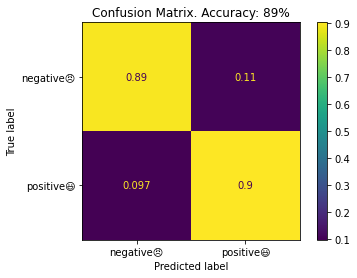

In [140]:
# Classify the ratings as positive and negative
X = df['review']
Y = df[['rating']].copy()
Y.loc[Y['rating'] <= 5, 'rating'] = 0
Y.loc[Y['rating'] > 5, 'rating'] = 1

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15)
tfidif_vectorizer = TfidfVectorizer(tokenizer=StemmingTokenizer())
X_train2 = tfidif_vectorizer.fit_transform(X_train)
X_val2 = tfidif_vectorizer.transform(X_val)
classifier = LogisticRegression(max_iter=3000, solver="saga")
classifier.fit(X_train2, np.ravel(Y_train))
predicted_val = classifier.predict(X_val2)

f1_result = f1_score(Y_val, predicted_val)
accuracy_result = accuracy_score(Y_val, predicted_val)
precision_result = precision_score(Y_val, predicted_val)
recall_result = recall_score(Y_val, predicted_val)

print("F1-Score: ", f1_result)
print("Accuracy: ", accuracy_result)
print("Precision: ", precision_result)
print("Recall: ", recall_result)

# Labels so it's more clear
names =['negative😠', 'positive😃']
cfmatr = confusion_matrix(Y_val, predicted_val, normalize='true')
cmd = ConfusionMatrixDisplay(cfmatr, display_labels=names)

cmd.plot()
cmd.ax_.set_title("Confusion Matrix. Accuracy: "+str(int(accuracy_result*100))+"%")
plt.show()

Based on the results and the corresponding confusion matrix, the classifier demonstrates excellent performance with an impressive F1-score of 90% on the validation data, along with consistent performance across all metrics. Additionally, it showcases efficiency, completing the training and classification process in approximately 2 minutes.

### Predictions on Unseen Data

To evaluate the final model on an unknown dataset the `sentiment_classification` function takes the path of the dataset as a parameter, trains the model and makes the predictions, which are returned as a vector.

In [134]:
def sentiment_classification(traindata, testdata):

    # Readinf the two files
    df = pd.read_csv(traindata, sep = '\t')
    test_df = pd.read_csv(testdata, sep = '\t')

    # Classify the TEST ratings as positive and negative
    X_test = test_df['review']
    Y_test = test_df[['rating']].copy()
    Y_test.loc[Y_test['rating'] <= 5, 'rating'] = 0
    Y_test.loc[Y_test['rating'] > 5, 'rating'] = 1

    # Classify the TRAIN ratings as positive and negative
    X = df['review']
    Y = df[['rating']].copy()
    Y.loc[Y['rating'] <= 5, 'rating'] = 0
    Y.loc[Y['rating'] > 5, 'rating'] = 1

    # Keeping the 0.85 from the train data as before
    X_train, _, Y_train, _ = train_test_split(X, Y, test_size=0.15)

    tfidif_vectorizer = TfidfVectorizer(tokenizer=StemmingTokenizer())

    # Fit transform train data
    X_train = tfidif_vectorizer.fit_transform(X_train)

    # Transform test data
    X_test = tfidif_vectorizer.transform(X_test)

    classifier = LogisticRegression(max_iter=3000, solver="saga")
    classifier.fit(X_train, np.ravel(Y_train))

    # Predict using the classifier
    predicted_val = classifier.predict(X_test)

    # Then score and print the following metrics
    f1_result = f1_score(Y_test, predicted_val)
    accuracy_result = accuracy_score(Y_test, predicted_val)
    precision_result = precision_score(Y_test, predicted_val)
    recall_result = recall_score(Y_test, predicted_val)
    print("F1-Score: ", f1_result)
    print("Accuracy: ", accuracy_result)
    print("Precision: ", precision_result)
    print("Recall: ", recall_result)

    # Labels so it's more clear in the matrix
    names =['negative😠', 'positive😃']
    cfmatr = confusion_matrix(Y_test, predicted_val, normalize='true')
    cmd = ConfusionMatrixDisplay(cfmatr, display_labels=names)

    # Plot the confusion matrix
    cmd.plot()
    cmd.ax_.set_title("Confusion Matrix. Accuracy: "+str(int(accuracy_result*100))+"%")
    plt.show()

    return predicted_val

To test the classifier, follow these steps:

1. Provide the path of the CSV file you want to test by assigning it to the **testdata** parameter.
2. Run the cell.
3. Once the execution is complete, the metrics and confusion matrix will be printed.
4. The variable **predictions** will contain a vector with the class labels for each sample.

F1-Score:  0.9281123437224863
Accuracy:  0.9274351226448632
Precision:  0.9196911533763741
Recall:  0.9366891771814466


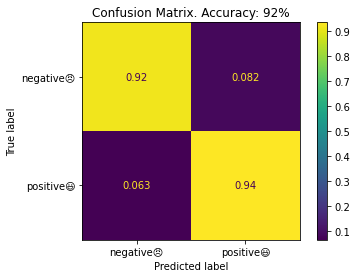

In [135]:
predictions = sentiment_classification(traindata="./imdb-reviews.csv", testdata="./yourfile.csv")